In [1]:
import torch
import torch.nn as nn


class Similarity1(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, encoder_states: torch.Tensor, decoder_state: torch.Tensor):
        # encoder_states.shape = [T, N]
        # decoder_state.shape = [N]
        # YOUR CODE HERE
        attention = torch.matmul(encoder_states.T, decoder_state.unsqueeze(1))
        return attention



In [2]:
import torch
import torch.nn as nn


class Similarity2(nn.Module):
    def __init__(self, encoder_dim: int, decoder_dim: int, intermediate_dim: int):
        super().__init__()

        self.fc1 = nn.Linear(encoder_dim, intermediate_dim)
        self.fc2 = nn.Linear(decoder_dim, intermediate_dim)
        self.fc3 = nn.Linear(intermediate_dim, 1)
        self.tanh = nn.Tanh()



    def forward(self, encoder_states: torch.Tensor, decoder_state: torch.Tensor):
        # encoder_states.shape = [T, N, encoder_dim]
        # decoder_state.shape = [N, decoder_dim]
        fc1_h = self.fc1(encoder_states)  # [T, N, intermediate_dim]
        s = decoder_state.unsqueeze(1)  # [N, 1, decoder_dim]
        fc2_s = self.fc2(s)  # [N, 1, intermediate_dim]
        fc2_s = fc2_s.expand_as(fc1_h)  # [T, N, intermediate_dim]
        attention = self.fc3(self.tanh(fc1_h + fc2_s)).squeeze(-1)  # [T, N]
        return attention


In [3]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [4]:
aneks = []

with open('9 anek.txt', 'r') as f:
    aneks.extend(f.read().split('\n'))

In [5]:
class Vocabulary:
    def __init__(self):
        self.vocabulary = ['_', '#', '<']  # sos, eos, pad
        self.vocabulary.extend('абвгдеёжзийклмнопрстуфхцчшщъыьэюя')
        self.vocabulary.extend('абвгдеёжзийклмнопрстуфхцчшщъыьэюя'.upper())
        self.vocabulary.extend('0123456789 ,.!?-')

        self._idx2char = {i: char for i, char in enumerate(self.vocabulary)}
        self._char2idx = {char: i for i, char in enumerate(self.vocabulary)}

    def get_vocabulary(self):
        return self.vocabulary

    def idx2char(self, idx: int):
        if idx not in self._idx2char:
            return '<'

        return self._idx2char[idx]

    def char2idx(self, char: str):
        if char not in self._char2idx:
            return self.get_pad()

        return self._char2idx[char]

    def encode(self, text):
        result = [self.char2idx(char) for char in text]

        result = [self.get_sos()] + result + [self.get_eos()]

        return result

    def get_sos(self):
        return self.char2idx('_')

    def get_eos(self):
        return self.char2idx('#')

    def get_pad(self):
        return self.char2idx('<')

In [6]:
from torch.utils.data import Dataset


class Anekdotes(Dataset):
    def __init__(self, aneks):
        self.aneks = aneks

        self.vocab = Vocabulary()

    def __getitem__(self, idx):
        return torch.LongTensor(self.vocab.encode(self.aneks[idx]))

    def __len__(self):
        return len(self.aneks)

In [7]:
dataset = Anekdotes(aneks)

In [8]:
from torch.utils.data import random_split


train_dataset, valid_dataset = random_split(dataset, (int(len(dataset) * 0.9), len(dataset) - int(len(dataset) * 0.9)))

In [9]:
from torch.nn.utils.rnn import pad_sequence


pad_idx = dataset.vocab.get_pad()


def collate_fn(batch):
    return pad_sequence([b[:256] for b in batch], padding_value=pad_idx, batch_first=True)

In [10]:
from torch.utils.data import DataLoader


train_loader = DataLoader(train_dataset, batch_size=256, collate_fn=collate_fn, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=256, collate_fn=collate_fn, pin_memory=True)

In [11]:
next(iter(train_loader)).shape

torch.Size([256, 256])

In [12]:
class AnekdoteRNN(nn.Module):
    def __init__(self, num_tokens: int, emb_size: int=32, hidden_size: int=256):
        super().__init__()

        self.embedding = nn.Embedding(num_tokens, emb_size, padding_idx = pad_idx)

        self.rnn = nn.LSTM(
            input_size=emb_size,
            hidden_size=hidden_size,
            num_layers=4,
            dropout=0.3,
            batch_first=True
        )

        self.attention = Similarity2(
            encoder_dim=hidden_size,
            decoder_dim=hidden_size,
            intermediate_dim=128
        )

        self.output = nn.Sequential(
            nn.Linear(2*hidden_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, num_tokens)
        )

    def forward(self, x):
        # Вход: x.shape = [N, T]
        x = self.embedding(x)  # [N, T, emb_size]
        rnn_output, (hidden, cell) = self.rnn(x)  # rnn_output.shape = [N, T, hidden_size]

        attention_weights = self.attention(rnn_output, hidden[-1])  # [N, T]
        attention_weights = torch.softmax(attention_weights, dim=-1)  # Нормализация весов

        # Взвешенная сумма выходов LSTM
        context_vector = torch.bmm(attention_weights.unsqueeze(1), rnn_output).squeeze(1)  # [N, hidden_size]

        # Генерация выхода для каждого шага
        # Расширяем context_vector до [N, T, hidden_size]
        context_vector = context_vector.unsqueeze(1).expand(-1, rnn_output.size(1), -1)  # [N, T, hidden_size]

        # Объединяем rnn_output и context_vector
        combined_output = torch.cat([rnn_output, context_vector], dim=-1)  # [N, T, 2 * hidden_size]

        # Генерация выхода
        output = self.output(combined_output)  # [N, T, num_tokens]

        return output

In [13]:
model = AnekdoteRNN(num_tokens=len(dataset.vocab.get_vocabulary()))

In [14]:
model

AnekdoteRNN(
  (embedding): Embedding(85, 32, padding_idx=2)
  (rnn): LSTM(32, 256, num_layers=4, batch_first=True, dropout=0.3)
  (attention): Similarity2(
    (fc1): Linear(in_features=256, out_features=128, bias=True)
    (fc2): Linear(in_features=256, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=1, bias=True)
    (tanh): Tanh()
  )
  (output): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=85, bias=True)
  )
)

In [15]:
from tqdm import tqdm


def train(model):
    model.train()

    train_loss = 0

    for x in tqdm(train_loader, desc='Train'):
        x = x.to(device)

        optimizer.zero_grad()

        output = model(x[:, :-1]).transpose(1, 2)

        loss = loss_fn(output, x[:, 1:])

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

    train_loss /= len(train_loader)

    return train_loss

In [16]:

x = next(iter(train_loader))

output = model(x[:, :-1])

print(output.shape)
print(x[:, 1:].shape)

print(output.transpose(1, 2).shape)

torch.Size([256, 255, 85])
torch.Size([256, 255])
torch.Size([256, 85, 255])


In [17]:
print(len(dataset.vocab.get_vocabulary()))

85


In [18]:
@torch.inference_mode()
def evaluate(model, loader):
    model.eval()

    total_loss = 0

    for x in tqdm(loader, desc='Evaluation'):
        x = x.to(device)

        output = model(x[:, :-1]).transpose(1, 2)

        loss = loss_fn(output, x[:, 1:])

        total_loss += loss.item()

    total_loss /= len(loader)

    return total_loss

In [19]:
def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

In [20]:
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []

    for epoch in range(num_epochs):
        train_loss = train(model)
        valid_loss = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        clear_output(wait=True)

        plot_stats(
            train_loss_history, valid_loss_history,
            title
        )

In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

cuda:0
Tesla T4


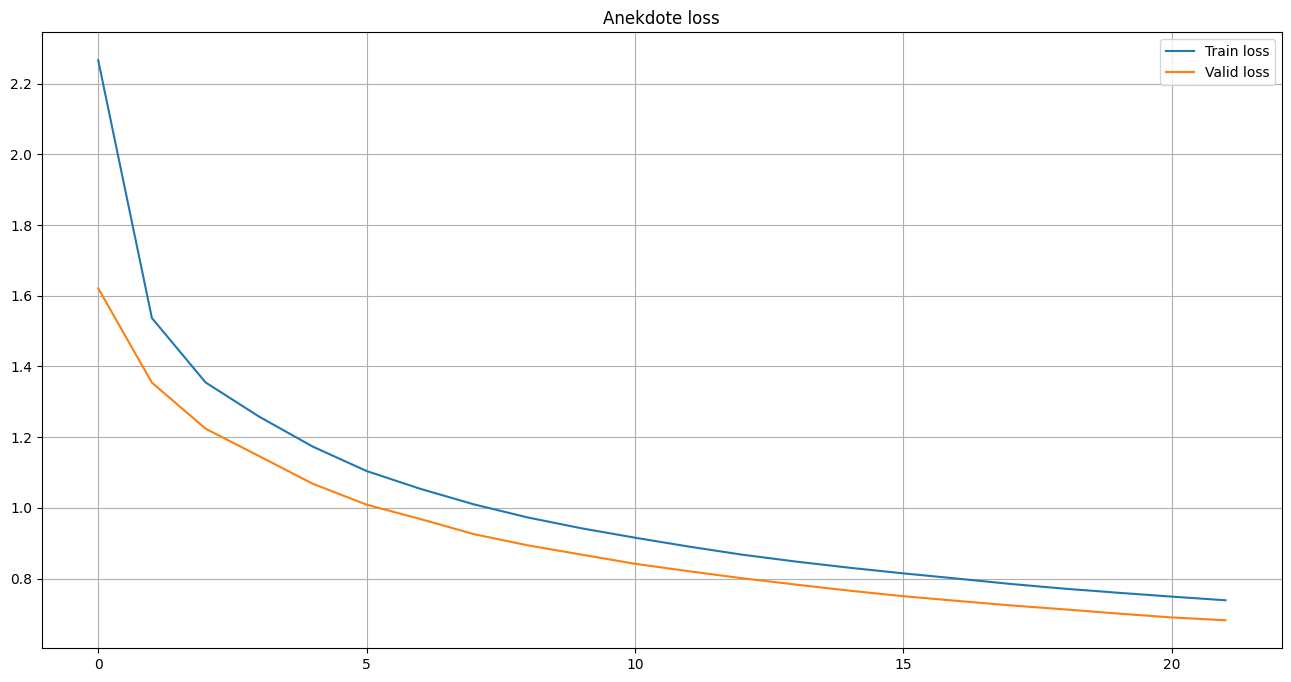

Train:  64%|██████▍   | 282/440 [01:20<00:45,  3.49it/s]

In [ ]:
from torch.optim import Adam


model = model.to(device)

optimizer = Adam(model.parameters(), lr=5e-3)

loss_fn = nn.CrossEntropyLoss(ignore_index=pad_idx)

whole_train_valid_cycle(model, 25, 'Anekdote')